Logistic Regression for the Titanic Dataset


In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier

In [398]:
# Load Dataset
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


In [399]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [400]:
data_train.head(), data_train.info(), data_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(   PassengerId  Survived  Pclass  \
 0            1         0       3   
 1            2         1       1   
 2            3         1       3   
 3            4         1       1   
 4            5         0       3   
 
                                                 Name     Sex   Age  SibSp  \
 0                            Braund, Mr. Owen Harris    male  22.0      1   
 1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                             Heikkinen, Miss. Laina  female  26.0      0   
 3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                           Allen, Mr. William Henry    male  35.0      0   
 
    Parch            Ticket     Fare Cabin Embarked  
 0      0         A/5 21171   7.2500   NaN        S  
 1      0          PC 17599  71.2833   C85        C  
 2      0  STON/O2. 3101282   7.9250   NaN        S  
 3      0            113803  53.1000  C123        S  
 4      0            373450   8.0500

Evaluate data and look for interesting plots. First let's look for correlation using a heatmap.

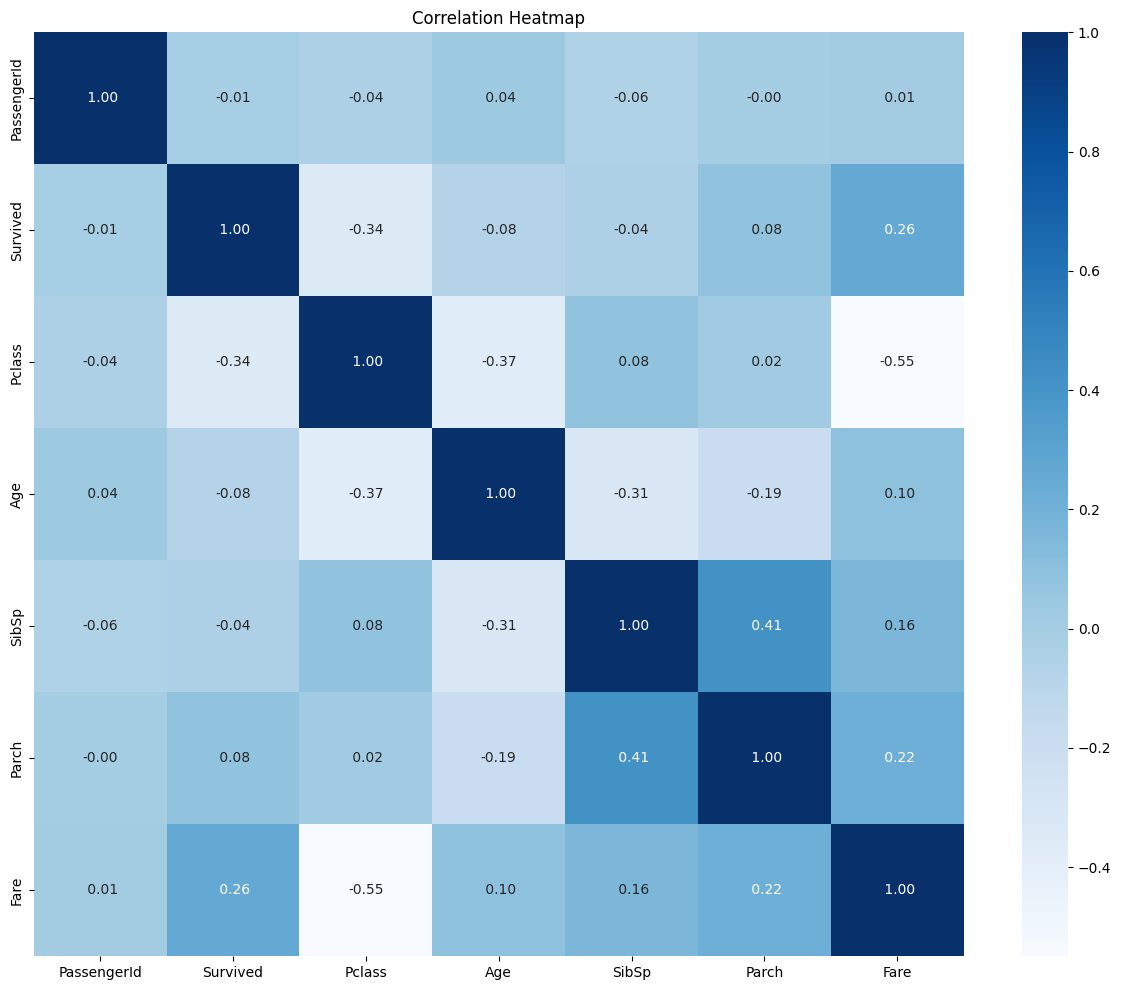

In [401]:
data_train_num = data_train.select_dtypes(include=['number'])
corr = data_train_num.corr()

plt.figure(figsize = (15,12))
sns.heatmap(corr, annot=True, fmt = " .2f", cmap = "Blues")
plt.title("Correlation Heatmap")
plt.show()

Fare seems to have the highest correlation with survivability. Let's explore this more. Notice that sex, which could also have strong correlation, is not show here as it not a number. We can fix this by encoding the data. Because there are only two sexes we can use binary.

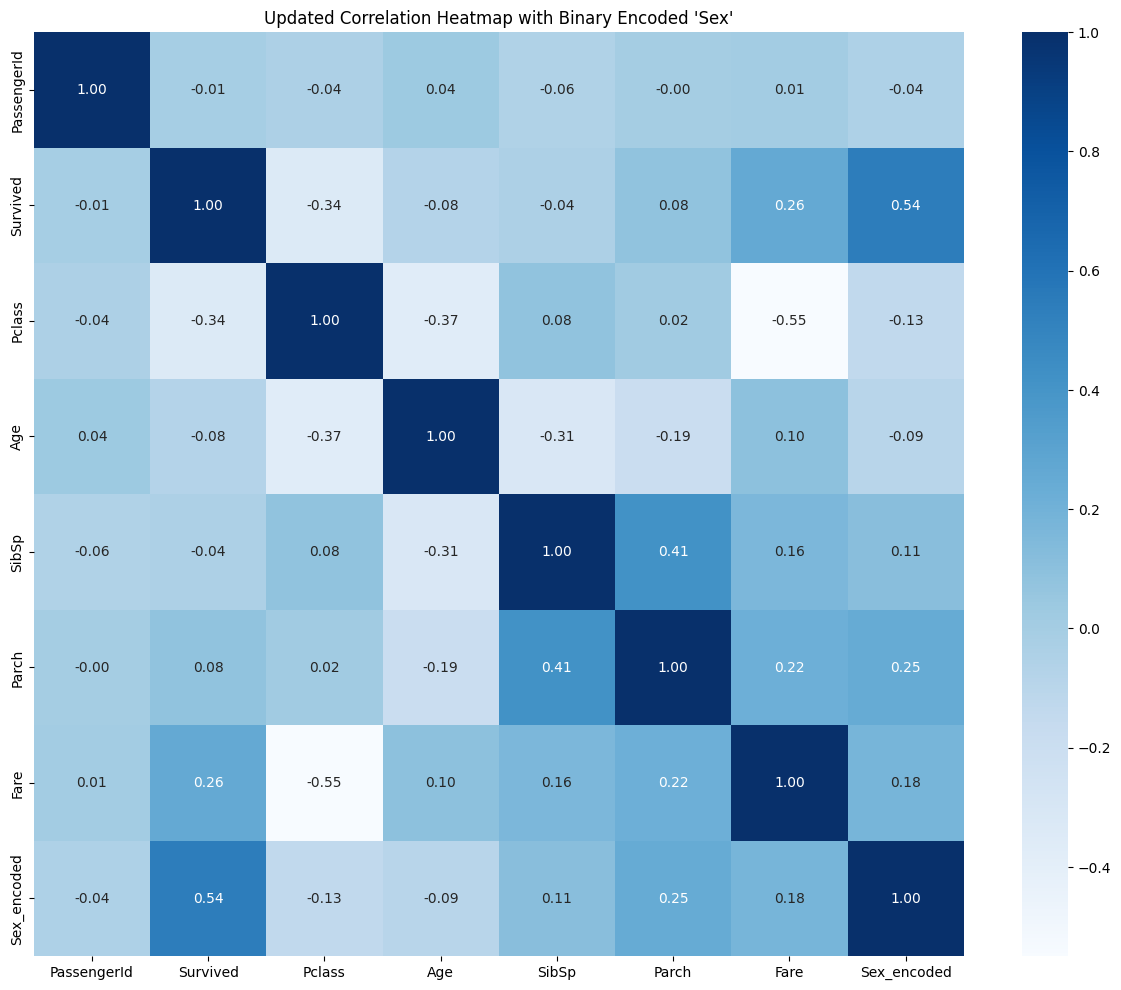

In [402]:
# Encode the 'Sex' column: male = 0, female = 1
data_train['Sex_encoded'] = data_train['Sex'].map({'male': 0, 'female': 1})

# Select numerical data types including the newly encoded 'Sex_encoded' column
data_train_num_updated = data_train.select_dtypes(include=['number'])

# Recalculate the correlation matrix
corr_updated = data_train_num_updated.corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_updated, annot=True, fmt=".2f", cmap="Blues")
plt.title("Updated Correlation Heatmap with Binary Encoded 'Sex'")
plt.show()


There is a strong correlation between sex and survival.

Looking through more of the numerical data, there is a 'ticket' column. Intially off put by the mix of numerical and alphanumberical data, some tickets containing prefixes make it look very messy. However, I noticed that some ticket numbers were duplicates. Instances of mutiple identical ticket numbers in this case appear to be mostly families (supported by SibSp/Parch Column), couples or friends travelling together, often sharing a surname. Now if we create a surnames column and use it with a ticket group coulmn then we may be able to be

In [403]:
# Extract surnames and add them into df

data_train['Surname'] = data_train['Name'].apply(lambda x: x.split(',')[0])


In [404]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Allen


In [405]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Allen


In [406]:
# Count how many times each ticket appears
ticket_counts = data_train['Ticket'].value_counts()

# Map the ticket counts back to the original data frame
data_train['Ticket_Count'] = data_train['Ticket'].apply(lambda x: ticket_counts[x])

# Create a binary indicator for shared tickets
data_train['Shared_Ticket'] = (data_train['Ticket_Count'] > 1).astype(int)


In [407]:
data_train = pd.get_dummies(data_train, columns=['Embarked'], dtype = 'int64')


In [408]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_encoded,Surname,Ticket_Count,Shared_Ticket,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,Braund,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,Cumings,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,Heikkinen,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1,Futrelle,2,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,Allen,1,0,0,0,1


In [409]:
data_train['Deck'] = data_train['Cabin'].str[0]  # Extract the deck letter



In [410]:
data_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_encoded,Surname,Ticket_Count,Shared_Ticket,Embarked_C,Embarked_Q,Embarked_S,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,Braund,1,0,0,0,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,Cumings,1,0,1,0,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,Heikkinen,1,0,0,0,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1,Futrelle,2,1,0,0,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,Allen,1,0,0,0,1,NaN


In [411]:
data_train = pd.get_dummies(data_train, columns=['Deck'], dummy_na=True, dtype = 'int64')


In [412]:
# Calculate frequencies
surname_frequencies = data_train['Surname'].value_counts()

# Map frequencies back to the data frame
data_train['Surname_Frequency'] = data_train['Surname'].map(surname_frequencies)


In [413]:
data_train = data_train.drop(columns=['Name', 'PassengerId', 'Sex', 'Ticket', 'Shared_Ticket', 'Cabin', 'Surname'])
data_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Ticket_Count,Embarked_C,Embarked_Q,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Surname_Frequency
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2
1,1,1,38.0,1,0,71.2833,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,1,35.0,1,0,53.1000,1,2,0,0,...,0,0,1,0,0,0,0,0,0,2
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2


In [414]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   Age                714 non-null    float64
 3   SibSp              891 non-null    int64  
 4   Parch              891 non-null    int64  
 5   Fare               891 non-null    float64
 6   Sex_encoded        891 non-null    int64  
 7   Ticket_Count       891 non-null    int64  
 8   Embarked_C         891 non-null    int64  
 9   Embarked_Q         891 non-null    int64  
 10  Embarked_S         891 non-null    int64  
 11  Deck_A             891 non-null    int64  
 12  Deck_B             891 non-null    int64  
 13  Deck_C             891 non-null    int64  
 14  Deck_D             891 non-null    int64  
 15  Deck_E             891 non-null    int64  
 16  Deck_F             891 non

We need to convert everything into numberical data for the algorithms to work effectively.

Let's train some models now and see where we get to in terms of accuracy. We can then play around with the test data to see if our models are more or less accurate.


We'll use 3 different algorithms of our Logistic Regression from Scikitlearn.

1. Linear Model Logistic regression
2. RandomForestClassifier
3. Hyperplan SVC

In [415]:
nan_values = data_train.isna().sum()

print("Columns with NaN values:")
print(nan_values[nan_values > 0])

Columns with NaN values:
Age    177
dtype: int64


In [416]:
data_train['Age'].fillna(data_train['Age'].median(), inplace=True) #replace NaN with median age values of passengers


C:\Users\aadon\AppData\Local\Temp\ipykernel_99376\3358491880.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['Age'].fillna(data_train['Age'].median(), inplace=True) #replace NaN with median age values of passengers


In [417]:
data_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Ticket_Count,Embarked_C,Embarked_Q,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Surname_Frequency
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2
1,1,1,38.0,1,0,71.2833,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,1,35.0,1,0,53.1000,1,2,0,0,...,0,0,1,0,0,0,0,0,0,2
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2


In [418]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   Age                891 non-null    float64
 3   SibSp              891 non-null    int64  
 4   Parch              891 non-null    int64  
 5   Fare               891 non-null    float64
 6   Sex_encoded        891 non-null    int64  
 7   Ticket_Count       891 non-null    int64  
 8   Embarked_C         891 non-null    int64  
 9   Embarked_Q         891 non-null    int64  
 10  Embarked_S         891 non-null    int64  
 11  Deck_A             891 non-null    int64  
 12  Deck_B             891 non-null    int64  
 13  Deck_C             891 non-null    int64  
 14  Deck_D             891 non-null    int64  
 15  Deck_E             891 non-null    int64  
 16  Deck_F             891 non

In [419]:
data_to_use = data_train.iloc[:, 1:20]
data_to_target = data_train.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=900)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=123)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Support Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svc)}")


Logistic Regression Accuracy: 0.8156424581005587


Random Forest Accuracy: 0.7821229050279329
SVM Accuracy: 0.664804469273743


Attempt to improv using different kernels for SVM

In [420]:
# create an object for svm

clfLinear = svm.SVC(kernel='linear')
clfsigmoid = svm.SVC(kernel='sigmoid')
clfrbf = svm.SVC(kernel='rbf')

clfLinear.fit(X_train, y_train)
clfsigmoid.fit(X_train, y_train)
clfrbf.fit(X_train, y_train)

SVC()

In [421]:
y_pred_linear = clfLinear.predict(X_test)
y_pred_sigmoid = clfsigmoid.predict(X_test)
y_pred_rbf = clfrbf.predict(X_test)

In [422]:
# check accuracy
from sklearn import metrics
print('Accuracy(linear)', metrics.accuracy_score(y_test, y_pred_linear))
print('Accuracy(sigmoid)', metrics.accuracy_score(y_test, y_pred_sigmoid))
print('Accuracy(rbf)', metrics.accuracy_score(y_test, y_pred_rbf))

Accuracy(linear) 0.7877094972067039
Accuracy(sigmoid) 0.6312849162011173
Accuracy(rbf) 0.664804469273743


The Linear kernal performs better and close to the scores achieved by Linear Regression and Random Forrest.

We'll add KNN now to the algo's and run that along sine the others from now on.

In [423]:
## build our knn model

knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [424]:
# make prediction

y_pred_knn = knn_model.predict(X_test)

In [425]:
print('Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

Accuracy 0.7430167597765364


In [426]:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print('SVM Accuracy(Linear)', metrics.accuracy_score(y_test, y_pred_linear))
print('KNN Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

Logistic Regression Accuracy: 0.8156424581005587
Random Forest Accuracy: 0.7821229050279329
SVM Accuracy(Linear) 0.7877094972067039
KNN Accuracy 0.7430167597765364


In order to optimise KNN we'll iterate through N Values to see which brings the highest score.

    n_neighbors  Accuracy
0             1  0.698324
1             2  0.687151
2             3  0.720670
3             4  0.726257
4             5  0.709497
5             6  0.715084
6             7  0.726257
7             8  0.715084
8             9  0.726257
9            10  0.731844
10           11  0.743017
11           12  0.726257
12           13  0.726257
13           14  0.737430
14           15  0.731844
15           16  0.743017
16           17  0.737430
17           18  0.726257
18           19  0.743017
19           20  0.715084
20           21  0.726257
21           22  0.720670
22           23  0.731844
23           24  0.720670
24           25  0.731844
25           26  0.715084
26           27  0.737430
27           28  0.726257
28           29  0.709497
29           30  0.698324


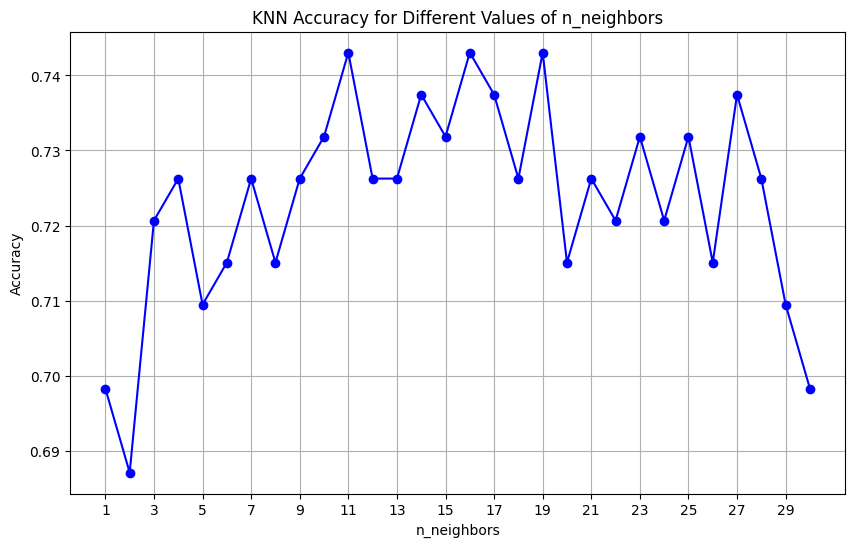

In [427]:
# Initialize lists to store accuracies and corresponding k values
accuracies = []
k_values = range(1, 31)

# Loop over values of k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_knn)
    accuracies.append(accuracy)


# Create a DataFrame from the accuracies and k_values
accuracy_df1 = pd.DataFrame({
    'n_neighbors': k_values,
    'Accuracy': accuracies
})

# Display the DataFrame
print(accuracy_df1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(list(k_values)[::2])  # Show every other integer label for readability
plt.grid(True)
plt.show()


Now to check if processing the data extensively actually helped the accuracy of the models - will start with the original data set and just remove alphanumerical columns only.



In [428]:
data_train = pd.read_csv('train.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [429]:
data_train = data_train.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis= 1)
data_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [430]:
nan_values = data_train.isna().sum()

print("Columns with NaN values:")
print(nan_values[nan_values > 0])

Columns with NaN values:
Age    177
dtype: int64


In [431]:
data_train['Age'].fillna(data_train['Age'].median(), inplace=True) # add median age to nan values again

C:\Users\aadon\AppData\Local\Temp\ipykernel_99376\2477400991.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['Age'].fillna(data_train['Age'].median(), inplace=True) # add median age to nan values again


In [432]:
data_to_use = data_train.iloc[:, 1:5]
data_to_target = data_train.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=123)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Support Vector Machine
clfLinear = svm.SVC(kernel='linear')
clfLinear.fit(X_train, y_train)
y_pred_linear = clfLinear.predict(X_test)
print('SVM Accuracy(linear)', metrics.accuracy_score(y_test, y_pred_linear))

## KNN 
knn_model = KNeighborsClassifier(n_neighbors=13)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print('KNN Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

Logistic Regression Accuracy: 0.7430167597765364
Random Forest Accuracy: 0.7094972067039106
SVM Accuracy(linear) 0.6871508379888268
KNN Accuracy 0.7206703910614525


Iterate NN again

    n_neighbors  Accuracy
0             1  0.608939
1             2  0.620112
2             3  0.664804
3             4  0.692737
4             5  0.692737
5             6  0.698324
6             7  0.698324
7             8  0.703911
8             9  0.692737
9            10  0.687151
10           11  0.698324
11           12  0.703911
12           13  0.720670
13           14  0.675978
14           15  0.692737
15           16  0.670391
16           17  0.698324
17           18  0.664804
18           19  0.664804
19           20  0.664804
20           21  0.664804
21           22  0.648045
22           23  0.664804
23           24  0.664804
24           25  0.687151
25           26  0.659218
26           27  0.664804
27           28  0.648045
28           29  0.631285
29           30  0.648045


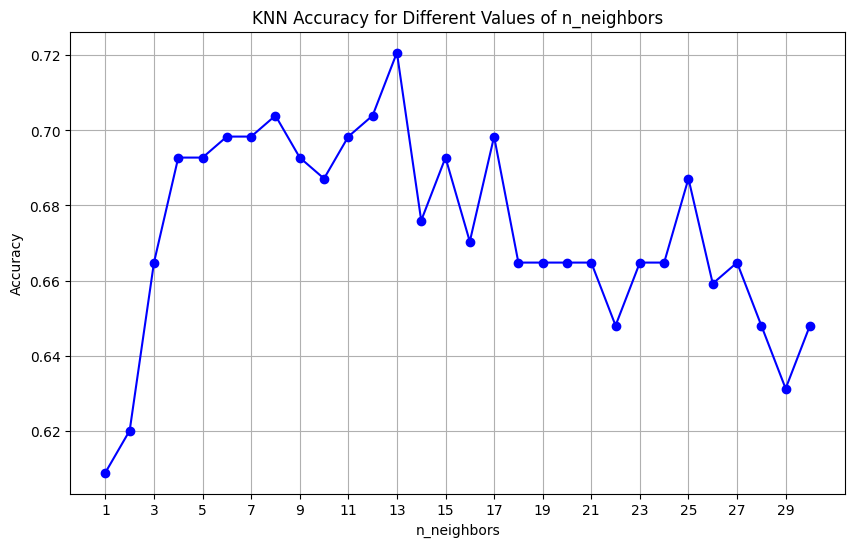

In [433]:
# Initialize lists to store accuracies and corresponding k values
accuracies = []
k_values = range(1, 31)

# Loop over values of k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_knn)
    accuracies.append(accuracy)

accuracy_df2 = pd.DataFrame({
    'n_neighbors': k_values,
    'Accuracy': accuracies
})

print(accuracy_df2)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(list(k_values)[::2])  # Show every other integer label for readability
plt.grid(True)
plt.show()

Add Bucketing to create another data set. Will apply bucketing to Fare, Age and Family size.

In [434]:
# bucketing
data_train = pd.read_csv('train.csv')

# Encode the 'Sex' column: male = 0, female = 1
data_train['Sex_encoded'] = data_train['Sex'].map({'male': 0, 'female': 1})

data_train['Surname'] = data_train['Name'].apply(lambda x: x.split(',')[0])

ticket_counts = data_train['Ticket'].value_counts()

# Map the ticket counts back to the original data frame
data_train['Ticket_Count'] = data_train['Ticket'].apply(lambda x: ticket_counts[x])

# Create a binary indicator for shared tickets
data_train['Shared_Ticket'] = (data_train['Ticket_Count'] > 1).astype(int)

data_train = pd.get_dummies(data_train, columns=['Embarked'], dtype = 'int64')

data_train['Deck'] = data_train['Cabin'].str[0]  # Extract the deck letter

data_train = pd.get_dummies(data_train, columns=['Deck'], dummy_na=True, dtype = 'int64')

# Calculate frequencies
surname_frequencies = data_train['Surname'].value_counts()

# Map frequencies back to the data frame
data_train['Surname_Frequency'] = data_train['Surname'].map(surname_frequencies)

data_train = data_train.drop(columns=['Name', 'PassengerId', 'Sex', 'Ticket', 'Shared_Ticket', 'Cabin', 'Surname'])
data_train.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Ticket_Count,Embarked_C,Embarked_Q,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Surname_Frequency
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2
1,1,1,38.0,1,0,71.2833,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,1,35.0,1,0,53.1000,1,2,0,0,...,0,0,1,0,0,0,0,0,0,2
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2


In [435]:
# Bucketing 'Age' into 'Age_Group'
data_train['Age'].fillna(data_train['Age'].median(), inplace=True)
bins_age = [0, 12, 18, 60, 120]
labels_age = [1, 2, 3, 4]
data_train['Age_Group'] = pd.cut(data_train['Age'], bins=bins_age, labels=labels_age, right=False)

# Bucketing 'Fare' into 'Fare_Level'
data_train['Fare_Level'] = pd.qcut(data_train['Fare'], q=4, labels=[1, 2, 3, 4])

# Bucketing 'Surname_Frequency' into 'Family_Size'
bins_family = [0, 1, 4, 11]
labels_family = [1, 2, 3]
data_train['Family_Size'] = pd.cut(data_train['Surname_Frequency'], bins=bins_family, labels=labels_family, right=False)

# Now, your training_data DataFrame has the new columns added to it
print(data_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Survived           891 non-null    int64   
 1   Pclass             891 non-null    int64   
 2   Age                891 non-null    float64 
 3   SibSp              891 non-null    int64   
 4   Parch              891 non-null    int64   
 5   Fare               891 non-null    float64 
 6   Sex_encoded        891 non-null    int64   
 7   Ticket_Count       891 non-null    int64   
 8   Embarked_C         891 non-null    int64   
 9   Embarked_Q         891 non-null    int64   
 10  Embarked_S         891 non-null    int64   
 11  Deck_A             891 non-null    int64   
 12  Deck_B             891 non-null    int64   
 13  Deck_C             891 non-null    int64   
 14  Deck_D             891 non-null    int64   
 15  Deck_E             891 non-null    int64   
 16  Deck_F  

C:\Users\aadon\AppData\Local\Temp\ipykernel_99376\2604852659.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['Age'].fillna(data_train['Age'].median(), inplace=True)


In [436]:
data_to_use = data_train.iloc[:, 1:23]
data_to_target = data_train.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=123)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Support Vector Machine
clfLinear = svm.SVC(kernel='linear')
clfLinear.fit(X_train, y_train)
y_pred_linear = clfLinear.predict(X_test)
print('SVM Accuracy(linear)', metrics.accuracy_score(y_test, y_pred_linear))

## KNN 
knn_model = KNeighborsClassifier(n_neighbors=17)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print('KNN Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

Logistic Regression Accuracy: 0.7988826815642458
Random Forest Accuracy: 0.8044692737430168
SVM Accuracy(linear) 0.7877094972067039
KNN Accuracy 0.7597765363128491


Iterate NN again.

    n_neighbors  Accuracy
0             1  0.692737
1             2  0.703911
2             3  0.726257
3             4  0.731844
4             5  0.726257
5             6  0.720670
6             7  0.709497
7             8  0.731844
8             9  0.726257
9            10  0.715084
10           11  0.731844
11           12  0.720670
12           13  0.743017
13           14  0.748603
14           15  0.748603
15           16  0.754190
16           17  0.759777
17           18  0.737430
18           19  0.737430
19           20  0.737430
20           21  0.737430
21           22  0.731844
22           23  0.754190
23           24  0.720670
24           25  0.737430
25           26  0.726257
26           27  0.731844
27           28  0.720670
28           29  0.715084
29           30  0.709497


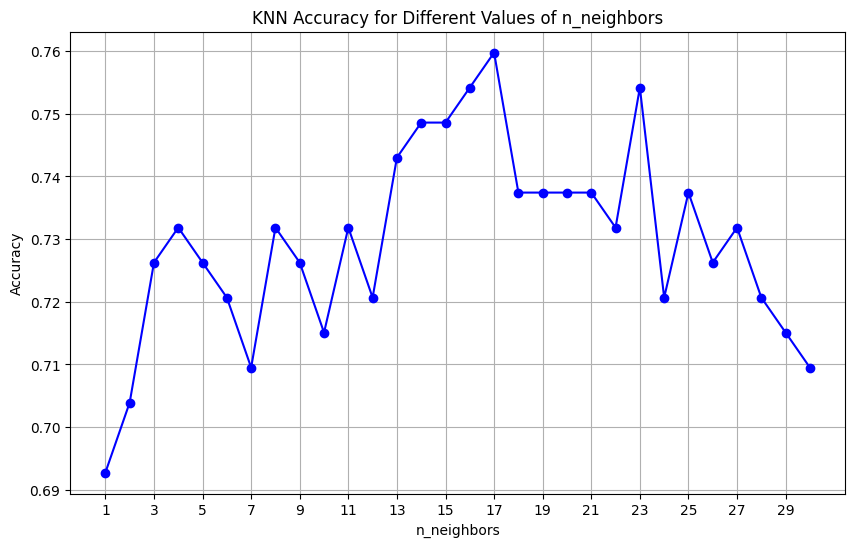

In [437]:
accuracies = []
k_values = range(1, 31)

# Loop over values of k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_knn)
    accuracies.append(accuracy)

accuracy_df3 = pd.DataFrame({
    'n_neighbors': k_values,
    'Accuracy': accuracies
})

print(accuracy_df3)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(list(k_values)[::2])  # Show every other integer label for readability
plt.grid(True)
plt.show()

In [438]:
data_train.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Ticket_Count,Embarked_C,Embarked_Q,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Surname_Frequency,Age_Group,Fare_Level,Family_Size
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,1,2,3,1,2
1,1,1,38.0,1,0,71.2833,1,1,1,0,...,0,0,0,0,0,0,1,3,4,2
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,1,1,3,2,2
3,1,1,35.0,1,0,53.1000,1,2,0,0,...,0,0,0,0,0,0,2,3,4,2
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,1,2,3,2,2


I realised the Age column would probably double represent the age bucketing we did, so i created a final training set without the age column to see if there was any difference.

In [439]:
data_train = data_train.drop(columns=['Age'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Survived           891 non-null    int64   
 1   Pclass             891 non-null    int64   
 2   SibSp              891 non-null    int64   
 3   Parch              891 non-null    int64   
 4   Fare               891 non-null    float64 
 5   Sex_encoded        891 non-null    int64   
 6   Ticket_Count       891 non-null    int64   
 7   Embarked_C         891 non-null    int64   
 8   Embarked_Q         891 non-null    int64   
 9   Embarked_S         891 non-null    int64   
 10  Deck_A             891 non-null    int64   
 11  Deck_B             891 non-null    int64   
 12  Deck_C             891 non-null    int64   
 13  Deck_D             891 non-null    int64   
 14  Deck_E             891 non-null    int64   
 15  Deck_F             891 non-null    int64   
 16  Deck_G  

In [440]:
data_to_use = data_train.iloc[:, 1:21]
data_to_target = data_train.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=123)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Support Vector Machine
clfLinear = svm.SVC(kernel='linear')
clfLinear.fit(X_train, y_train)
y_pred_linear = clfLinear.predict(X_test)
print('SVM Accuracy(linear)', metrics.accuracy_score(y_test, y_pred_linear))

## KNN 
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print('KNN Accuracy', metrics.accuracy_score(y_test, y_pred_knn))

Logistic Regression Accuracy: 0.8044692737430168
Random Forest Accuracy: 0.8044692737430168
SVM Accuracy(linear) 0.7877094972067039
KNN Accuracy 0.7877094972067039


Iterate through NN again.

    n_neighbors  Accuracy
0             1  0.737430
1             2  0.731844
2             3  0.765363
3             4  0.737430
4             5  0.770950
5             6  0.743017
6             7  0.787709
7             8  0.765363
8             9  0.776536
9            10  0.776536
10           11  0.787709
11           12  0.782123
12           13  0.782123
13           14  0.754190
14           15  0.782123
15           16  0.765363
16           17  0.782123
17           18  0.754190
18           19  0.759777
19           20  0.703911
20           21  0.709497
21           22  0.715084
22           23  0.715084
23           24  0.709497
24           25  0.715084
25           26  0.715084
26           27  0.715084
27           28  0.709497
28           29  0.709497
29           30  0.720670


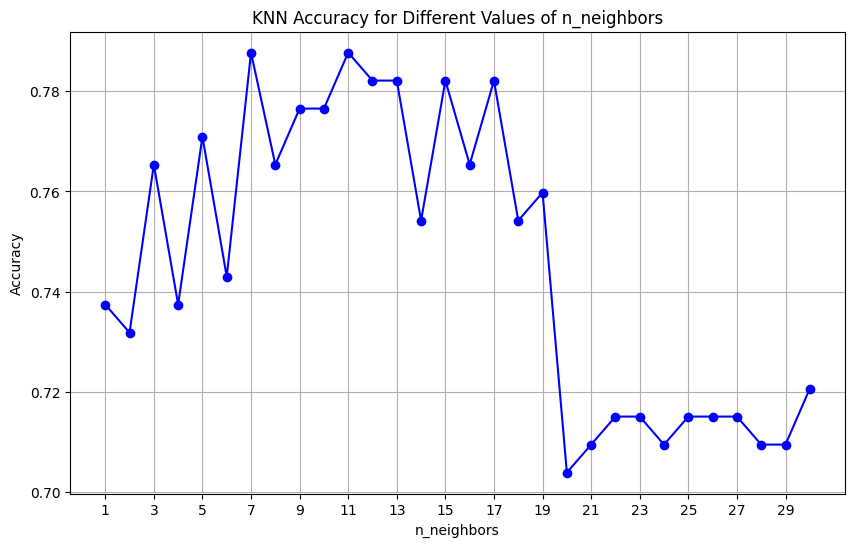

In [441]:
# Initialize lists to store accuracies and corresponding k values
accuracies = []
k_values = range(1, 31)

# Loop over values of k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_knn)
    accuracies.append(accuracy)

accuracy_df4 = pd.DataFrame({
    'n_neighbors': k_values,
    'Accuracy': accuracies
})

print(accuracy_df4)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(list(k_values)[::2])  # Show every other integer label for readability
plt.grid(True)
plt.show()

In [442]:
accuracy_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_neighbors  30 non-null     int64  
 1   Accuracy     30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 608.0 bytes


In [446]:
accuracy_df1['Experiment'] = 'Processed Data'
accuracy_df2['Experiment'] = 'Processed Minimum'
accuracy_df3['Experiment'] = 'Processed Bucket'
accuracy_df4['Experiment'] = 'Processed Bucket w/o age'



In [447]:
combined_df = pd.concat([accuracy_df1, accuracy_df2, accuracy_df3, accuracy_df4], ignore_index=True)


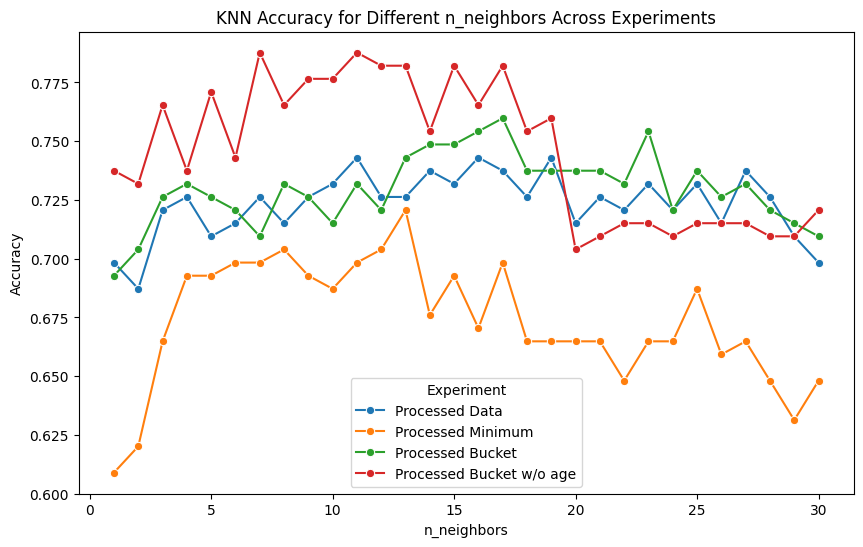

In [448]:


plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='n_neighbors', y='Accuracy', hue='Experiment', marker='o')
plt.title('KNN Accuracy for Different n_neighbors Across Experiments')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(title='Experiment')
plt.show()
